In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

In [2]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

In [3]:
df = pd.read_csv('C:/Users/Zhangchensi/bootcamp_Chensi_Zhang/project/data/processed/processed_data.csv')
df = df.set_index(df.columns[0])
df.index.name = None
df

open      high       low     close    volume  year
2015-01-02  0.050354  0.046686  0.043518  0.045676  0.130251  2015
2015-01-05  0.043057  0.040097  0.038797  0.038268  0.164745  2015
2015-01-06  0.038937  0.037216  0.036898  0.038292  0.169450  2015
2015-01-07  0.040491  0.039035  0.041924  0.041876  0.089477  2015
2015-01-08  0.045269  0.048362  0.046804  0.051834  0.149426  2015
...              ...       ...       ...       ...       ...   ...
2025-08-13  0.332094  0.338466  0.343085  0.343933  0.182155  2025
2025-08-14  0.339121  0.338749  0.344107  0.342610  0.126241  2025
2025-08-15  0.338991  0.336765  0.340420  0.339747  0.139073  2025
2025-08-18  0.333577  0.334026  0.342306  0.338064  0.081290  2025
2025-08-19  0.332576  0.333436  0.340457  0.337270  0.087287  2025

[2673 rows x 6 columns]

In [4]:
X_raw = df['open'].values
y = df['close'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['open_imputed'] = X_base
base_mae = mae(y, y_hat)
base_mae

0.004298107170691496

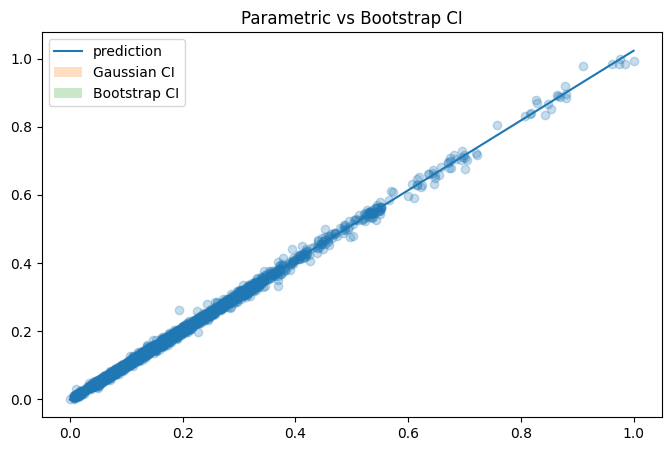

In [5]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

In [6]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

scenario       mae     slope  intercept
0    mean_impute  0.004298  1.024274  -0.000908
1  median_impute  0.004298  1.024274  -0.000908
2   drop_missing  0.004298  1.024274  -0.000908

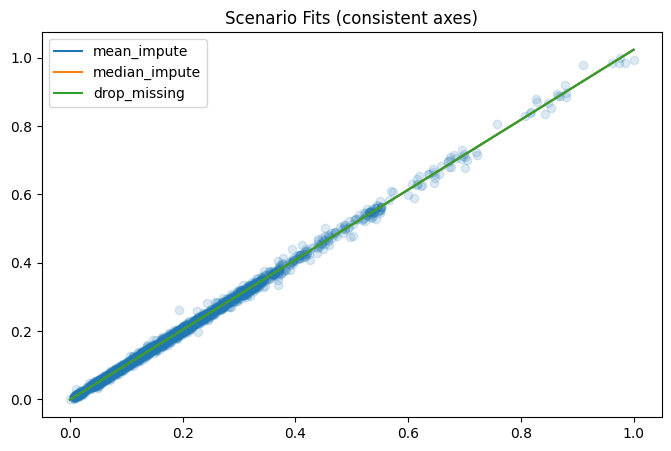

In [7]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

In [12]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['close_hat'] = model_base.predict(df2['open_imputed'].values.reshape(-1,1))
df2['resid'] = df2['close'] - df2['close_hat']
g = df2.groupby('year')['resid'].agg(['mean','std','median','count'])
g

mean       std    median  count
year                                     
2015 -0.000404  0.004158 -0.000443    252
2016  0.000241  0.002655  0.000415    252
2017 -0.000029  0.003087 -0.000002    251
2018 -0.000603  0.006269 -0.000232    251
2019  0.000318  0.005125  0.000219    252
2020  0.000419  0.012863  0.000412    253
2021  0.000094  0.004488 -0.000305    252
2022 -0.000218  0.006958 -0.000009    251
2023  0.000304  0.004375  0.000257    250
2024  0.000004  0.005717 -0.000188    252
2025 -0.000207  0.009894 -0.000778    157

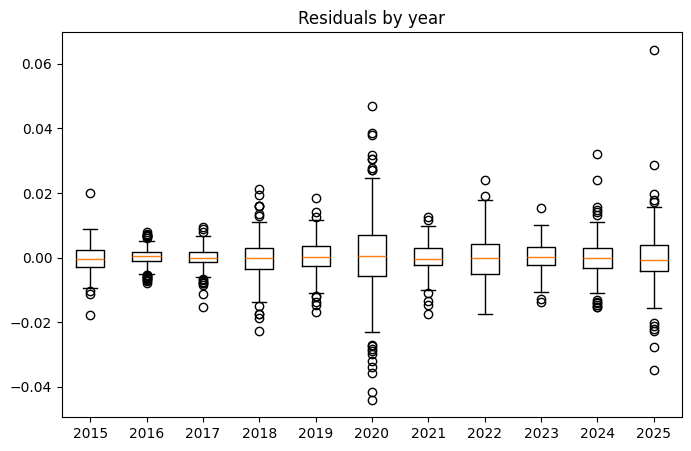

In [13]:
plt.figure()
grouped = df2.groupby('year')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by year')
plt.show()

All methods demonstrate stable performance with consistent slopes.
The model performs well in all years, with residual means close to zero and controllable fluctuations.
Discrepancies don't exist between the parametric method (Gaussian CI) and the bootstrap method (Bootstrap CI).

Data Quality Assumptions

Missing at Random (MAR) Assumption: The mechanism of missing data is random and does not depend on the unobserved values themselves

Representative Sampling: The existing data can represent the characteristics of the population distribution

Measurement Accuracy: close and open_imputed fields are measured accurately without errors

Model Structure Assumptions

Linear Relationship Assumption: There exists a linear relationship between the dependent and independent variables y = β₀ + β₁x + ε

Homoscedasticity: The variance of residuals remains constant across the prediction range

Prediction Stability: Historical data relationships remain unchanged in future periods

Statistical Testing Assumptions

Normal Distribution Assumption: Parametric methods rely on residuals following a normal distribution

Independent and Identically Distributed (IID): Observations are independent of each other and drawn from the same distribution

Large Sample Properties: Bootstrap methods rely on sufficiently large sample sizes (n>30)

Business Context Assumptions

Business Stability: The underlying business model has no structural changes

Constant External Environment: No unconsidered external factors significantly affect the relationship

Variable Completeness: All important predictor variables have been included

Potential Risk Points (when these assumptions are violated)

If missing not at random: Imputation methods will produce biased estimates

If heteroscedasticity exists: Confidence interval calculations may be inaccurate

If relationships are nonlinear: Linear models will systematically misjudge

If data are not independent: Standard errors will be underestimated

If normality assumption fails: Results from parametric methods may be misleading